2025-04-30 22:05:35.424790: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-30 22:05:35.424829: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-30 22:05:35.426025: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-30 22:05:35.432514: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-30 22:05:36.020721: W tensorflow/compiler/tf2

Epoch 1/15 — Avg Loss: 0.418934
Epoch 2/15 — Avg Loss: 0.370200
Epoch 3/15 — Avg Loss: 0.364245
Epoch 4/15 — Avg Loss: 0.322381
Epoch 5/15 — Avg Loss: 0.252813
Epoch 6/15 — Avg Loss: 0.192202
Epoch 7/15 — Avg Loss: 0.149919
Epoch 8/15 — Avg Loss: 0.122993
Epoch 9/15 — Avg Loss: 0.106508
Epoch 10/15 — Avg Loss: 0.095297
Epoch 11/15 — Avg Loss: 0.086566
Epoch 12/15 — Avg Loss: 0.081040
Epoch 13/15 — Avg Loss: 0.076393
Epoch 14/15 — Avg Loss: 0.072777
Epoch 15/15 — Avg Loss: 0.069677


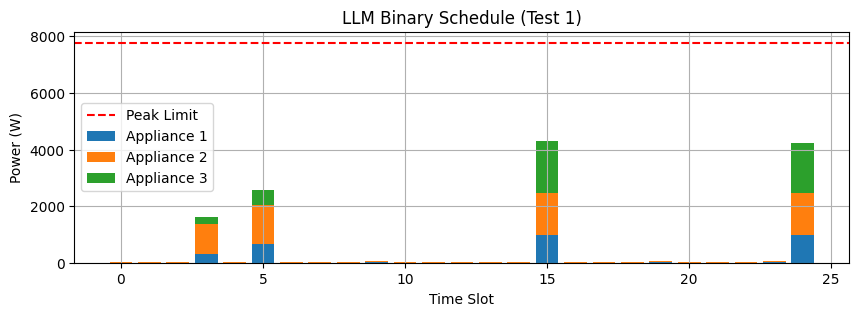

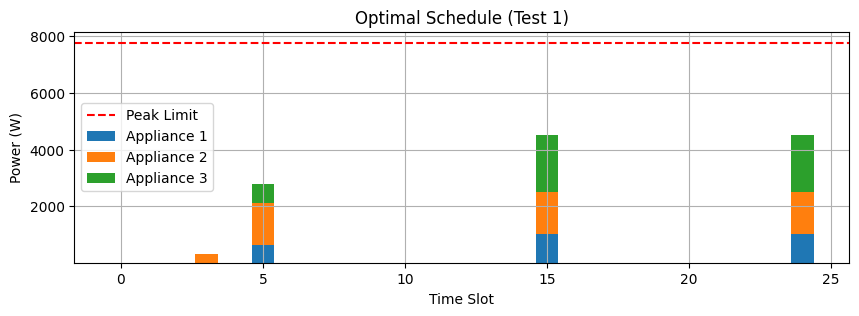

Test 1: Pred Cost=$0.99, Opt Cost=$0.83, Gap=$0.15



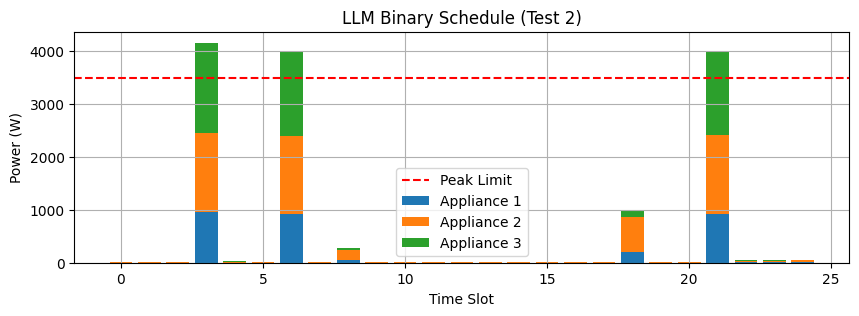

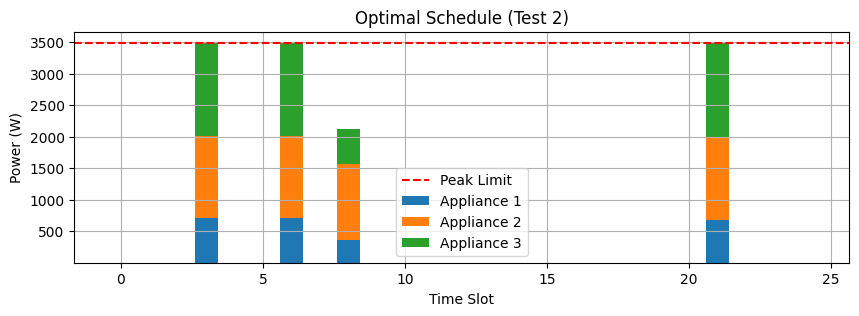

Test 2: Pred Cost=$0.79, Opt Cost=$0.70, Gap=$0.09



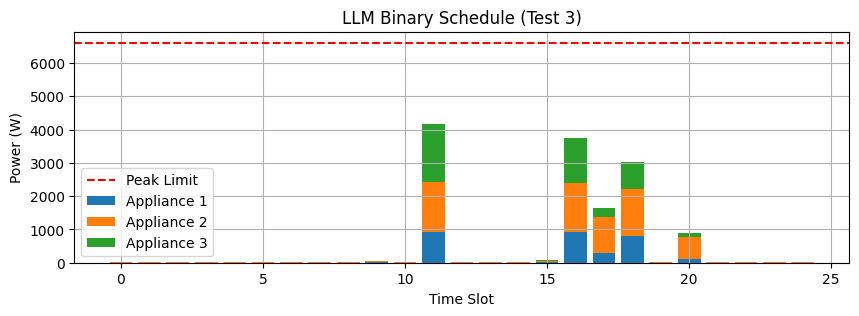

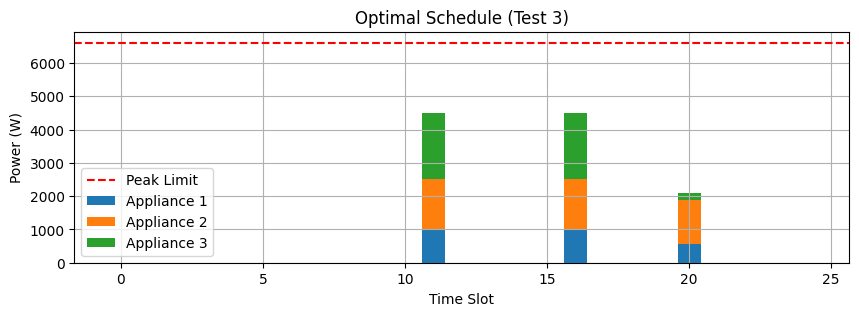

Test 3: Pred Cost=$1.16, Opt Cost=$0.78, Gap=$0.38



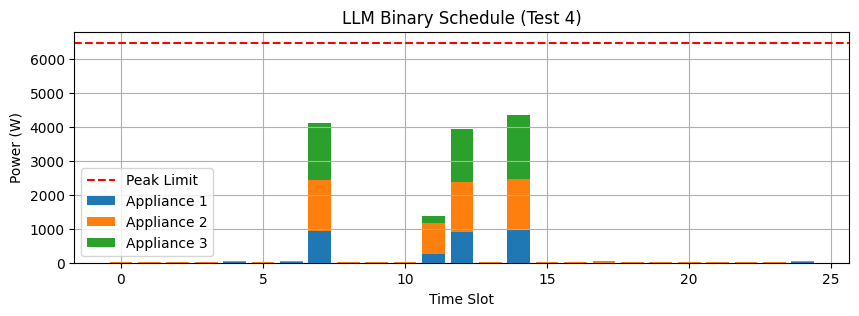

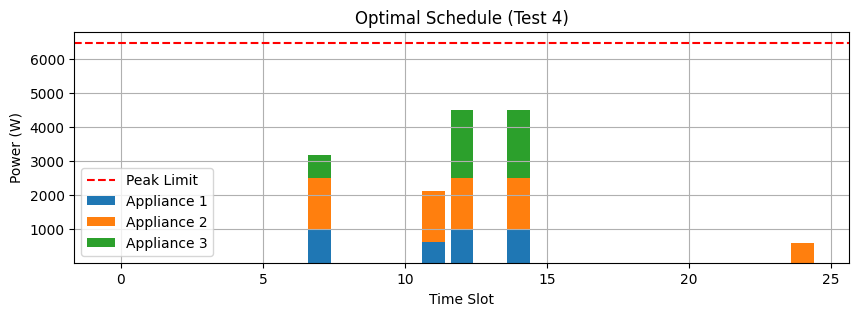

Test 4: Pred Cost=$1.00, Opt Cost=$1.01, Gap=$-0.01



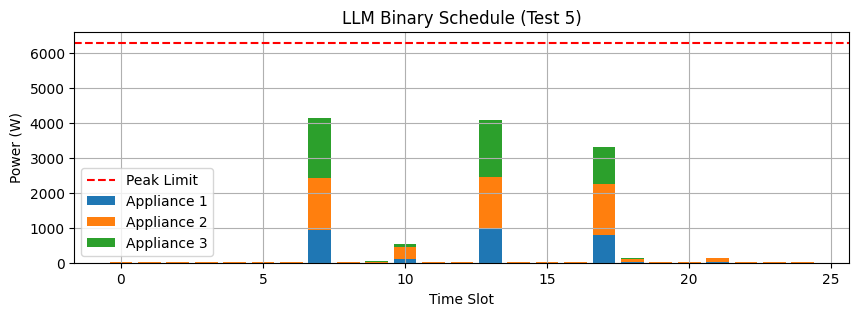

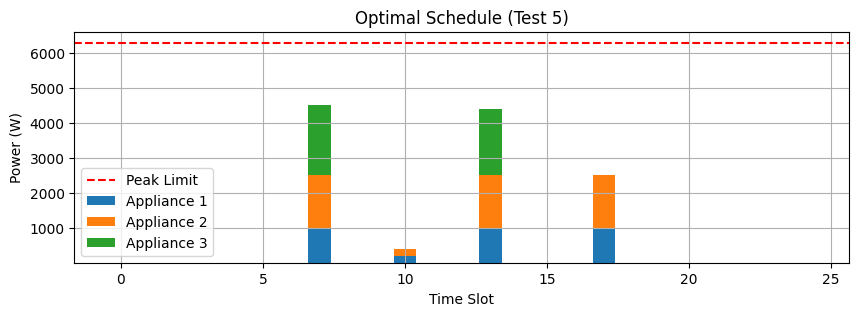

Test 5: Pred Cost=$0.93, Opt Cost=$0.82, Gap=$0.11



In [ ]:
import cvxpy as cp
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertModel
torch.cuda.empty_cache()

# 1) Convex oracle: solve the LP with default solver
def generate_optimal_schedule(price, P_h, E_h, peak_limit):
    N, H = len(price), len(P_h)
    X = cp.Variable((N, H))
    power = cp.multiply(X, P_h.reshape(1, H))
    cost = cp.sum(cp.multiply(price.reshape(N, 1), power)) / 1000.0
    constraints = [
        cp.sum(power, axis=0) >= E_h,
        cp.sum(power, axis=1) <= peak_limit,
        X >= 0, X <= 1
    ]
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve(verbose=False)
    # Round to 0/1
    return X.value.astype(float)

# 2) Structured Prompt Dataset
class TSLSupervisedDatasetStructured(Dataset):
    def __init__(self, n_samples, N, H):
        self.prompts = []
        self.targets = []
        self.N, self.H = N, H
        self.P_h = np.array([1000, 1500, 2000])  # Rated power for each appliance (3 devices now)

        # Define ranges for energy requirements (in Wh)
        self.E_h_ranges = np.array([
            [2000, 4000],  # Appliance 1 range
            [4000, 8000],  # Appliance 2 range
            [3000, 6000]    # Appliance 3 range
        ])

        # Define the range for the peak limit (in Watts)
        self.peak_range = (3000, 8000)  # Increased peak range for 3 devices

        for _ in range(n_samples):
            price = 0.05 + (0.2 - 0.05) * np.random.rand(N)
            # Sample energy requirements randomly from the defined ranges
            E_h = np.array([
                np.random.randint(self.E_h_ranges[0, 0], self.E_h_ranges[0, 1]),
                np.random.randint(self.E_h_ranges[1, 0], self.E_h_ranges[1, 1]),
                np.random.randint(self.E_h_ranges[2, 0], self.E_h_ranges[2, 1])
            ])
            # Sample a peak limit randomly from the given range for each sample
            peak_limit = np.random.randint(*self.peak_range)
            X_opt = generate_optimal_schedule(price, self.P_h, E_h, peak_limit)
            self.prompts.append(self._build_prompt(price, E_h, peak_limit))
            self.targets.append(torch.tensor(X_opt.flatten(), dtype=torch.float32))

    def _build_prompt(self, price, E_h, peak_limit):
        s = "[Prices]\n" + "\n".join(f"Slot {i+1}: {p:.3f} $/kWh" for i, p in enumerate(price))
        s += "\n\n[Appliances]\n"
        for i, (pw, eg) in enumerate(zip(self.P_h, E_h), start=1):
            s += (f"Appliance {i}:\n"
                  f"  Rated Power: {pw/1000:.1f} kW\n"
                  f"  Energy Required: {eg/1000:.1f} kWh\n")
        s += f"\n[Peak Limit]\n{peak_limit/1000:.1f} kW\n"
        s += "\n[Objective]\nMinimize total electricity cost.\n"
        s += f"\n[Output]\nProvide a {self.N}x{self.H} schedule matrix."
        return s

    def __len__(self):
        return len(self.prompts)

    def __getitem__(self, idx):
        return self.prompts[idx], self.targets[idx]

# 3) Model: BERT-base → logits
class SupervisedTSLModel(nn.Module):
    def __init__(self, N, H):
        super().__init__()
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        hidden = self.bert.config.hidden_size
        self.regressor = nn.Sequential(
            nn.Linear(hidden, hidden // 2),
            nn.ReLU(),
            nn.Linear(hidden // 2, N * H)
        )

    def forward(self, prompts):
        enc = self.tokenizer(prompts,
                             padding=True,
                             truncation=True,
                             return_tensors="pt")
        device = next(self.bert.parameters()).device
        enc = {k: v.to(device) for k, v in enc.items()}
        out = self.bert(**enc).last_hidden_state[:, 0, :]  # CLS token representation
        return self.regressor(out)

# 4) Training with BCEWithLogitsLoss to get binary schedules
def train_model(model, dataset, epochs=20, batch_size=16, lr=2e-5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optim = AdamW(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()

    for ep in range(1, epochs + 1):
        model.train()
        running = 0.0
        for prompts, targets in loader:
            logits = model(prompts).to(device)
            loss = loss_fn(logits, targets.to(device))
            optim.zero_grad()
            loss.backward()
            optim.step()
            running += loss.item() * targets.size(0)
        print(f"Epoch {ep}/{epochs} — Avg Loss: {running/len(dataset):.6f}")
    return model

# 5) Test & plot just stacked bars (binary schedules)
def test_and_plot(model, tests=3, N=25):
    P_h = np.array([1000, 1500, 2000])  # 3 devices now
    # Define the same energy ranges as in training
    E_h_ranges = np.array([
        [2000, 4000],  # Appliance 1 range
        [4000, 8000],   # Appliance 2 range
        [3000, 6000]    # Appliance 3 range
    ])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    model.eval().to(device)

    for t_i in range(1, tests + 1):
        price = 0.05 + (0.2 - 0.05) * np.random.rand(N)
        # Sample energy requirements randomly for testing
        E_h = np.array([
            np.random.randint(E_h_ranges[0, 0], E_h_ranges[0, 1]),
            np.random.randint(E_h_ranges[1, 0], E_h_ranges[1, 1]),
            np.random.randint(E_h_ranges[2, 0], E_h_ranges[2, 1])
        ])
        # Sample a new peak limit from the defined range for testing
        peak = np.random.randint(3000, 8000)

        # Build the prompt using the randomized values
        p = "[Prices]\n" + "\n".join(f"Slot {i+1}: {v:.3f} $/kWh" for i, v in enumerate(price))
        p += "\n\n[Appliances]\n"
        for i, (pw, eg) in enumerate(zip(P_h, E_h), start=1):
            p += (f"Appliance {i}:\n"
                  f"  Rated Power: {pw/1000:.1f} kW\n"
                  f"  Energy Required: {eg/1000:.1f} kWh\n")
        p += f"\n[Peak Limit]\n{peak/1000:.1f} kW\n"
        p += "\n[Objective]\nMinimize total electricity cost.\n"
        p += f"\n[Output]\nProvide a {N}x3 schedule matrix."

        # Predict using the model
        with torch.no_grad():
            enc = tokenizer([p], padding=True, truncation=True,
                            return_tensors="pt").to(device)
            out = model.bert(**enc).last_hidden_state[:, 0, :]
            logits = model.regressor(out)
            probs = torch.sigmoid(logits).cpu().numpy()[0].reshape(N, 3)
        bin_sched = probs.astype(float)

        # Get the optimal schedule for comparison
        opt_sched = generate_optimal_schedule(price, P_h, E_h, peak)

        # Plot predicted binary schedule
        t = np.arange(N)
        fig, ax = plt.subplots(1, 1, figsize=(10, 3))
        ax.bar(t, bin_sched[:, 0]*P_h[0], label="Appliance 1")
        ax.bar(t, bin_sched[:, 1]*P_h[1],
               bottom=bin_sched[:, 0]*P_h[0], label="Appliance 2")
        ax.bar(t, bin_sched[:, 2]*P_h[2],
               bottom=bin_sched[:, 0]*P_h[0] + bin_sched[:, 1]*P_h[1],
               label="Appliance 3")
        ax.axhline(peak, color='r', ls='--', label="Peak Limit")
        ax.set_title(f"LLM Binary Schedule (Test {t_i})")
        ax.set_xlabel("Time Slot")
        ax.set_ylabel("Power (W)")
        ax.legend(), ax.grid(True)
        plt.show()

        # Plot optimal schedule
        fig, ax = plt.subplots(1, 1, figsize=(10, 3))
        ax.bar(t, opt_sched[:, 0]*P_h[0], label="Appliance 1")
        ax.bar(t, opt_sched[:, 1]*P_h[1],
               bottom=opt_sched[:, 0]*P_h[0], label="Appliance 2")
        ax.bar(t, opt_sched[:, 2]*P_h[2],
               bottom=opt_sched[:, 0]*P_h[0] + opt_sched[:, 1]*P_h[1],
               label="Appliance 3")
        ax.axhline(peak, color='r', ls='--', label="Peak Limit")
        ax.set_title(f"Optimal Schedule (Test {t_i})")
        ax.set_xlabel("Time Slot")
        ax.set_ylabel("Power (W)")
        ax.legend(), ax.grid(True)
        plt.show()

        # Print cost summary
        cost_pred = (price[:, None] * (bin_sched * P_h)/1000.0).sum()
        cost_opt  = (price[:, None] * (opt_sched * P_h)/1000.0).sum()
        print(f"Test {t_i}: Pred Cost=${cost_pred:.2f}, Opt Cost=${cost_opt:.2f}, Gap=${cost_pred - cost_opt:.2f}\n")

# 6) Entry point
if __name__ == "__main__":
    torch.cuda.empty_cache()
    N, H = 25, 3  # Now H=3 for 3 devices
    ds = TSLSupervisedDatasetStructured(5000, N, H)
    model = SupervisedTSLModel(N, H)
    model = train_model(model, ds, epochs=15, batch_size=16, lr=2e-5)
    test_and_plot(model, tests=5, N=N)